## Classifying Crime Serverity (Violent vs Non-violent)

In [1]:
import pandas as pd

# Load dataset
dataset = pd.read_csv("Crime_Data_Preprocessed.csv")

# Violent crime keywords
violent_keywords = [
    'ABUSE', 'ACTS', 'AGGRAVATED', 'ANUS', 'ARSON', 'ASSAULT', 'ASSLT',
    'ATTEMPT', 'ATTEMPTED', 'BATTERY', 'BEASTIALITY', 'BRANDISH',
    'CHILD', 'CONTACT', 'CRIMINAL', 'DEADLY', 'ELDER', 'FORCIBLE',
    'HARM', 'HOMICIDE', 'INJURY', 'INTIMATE', 'KIDNAPPING', 'LEWD',
    'MANSLAUGHTER', 'PHYSICAL', 'POLICE', 'RAPE', 'ROBBERY', 'SEXUAL',
    'SIMPLE', 'SODOMY', 'THREATENING', 'THREATS', 'TRAFFICKING',
    'UNLAWFUL', 'VIOLATION', 'WEAPON'
]

def is_violent_crime(desc: str) -> bool:
    # Return True if crm_cd_desc contains any violent keyword
    if pd.isna(desc):
        return False
    d = desc.upper()
    return any(k in d for k in violent_keywords)

# Violent indicators based on weapon description
non_violent_weapons = ["UNKNOWN", "UNKNOWN WEAPON/OTHER WEAPON"]

def is_weapon_violent(weapon: str) -> bool:
    # Return True if a weapon is known and not marked as non-violent
    if pd.isna(weapon):
        return False
    w = weapon.upper().strip()
    return w not in non_violent_weapons

# Combination of crime description and weapon description to create violent flag
dataset["violent_flag"] = (
    dataset["crm_cd_desc"].apply(is_violent_crime) |
    dataset["weapon_desc"].apply(is_weapon_violent)
).astype(int)


# Count violent vs non-violent crimes
violent_counts = dataset["violent_flag"].value_counts()

print(violent_counts)

violent_flag
0    650547
1    354444
Name: count, dtype: int64


In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier


# Sampling to handle class imbalance

print("Sampling dataset")

violent = dataset[dataset["violent_flag"] == 1]
non_violent = dataset[dataset["violent_flag"] == 0]

v_samp = violent.sample(35000, random_state=42)    
nv_samp = non_violent.sample(45000, random_state=42)  

sampled = pd.concat([v_samp, nv_samp]).sample(frac=1, random_state=42)

# Feature selection and further preprocessing
num_features = ["vict_age", "lat", "lon", "hour", "month", "day", "area"]

cat_features = ["premis_desc", "status_desc", "area_name"]

X = sampled[num_features + cat_features]
y = sampled["violent_flag"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=50, sparse_output=False), cat_features)
    ]
)

# Train/Test Split
print("Splitting train and test")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)
print("\nSplit sizes (train, test):", len(X_train), len(X_test))



# Cross-validation and Hyperparameter Tuning
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Performing 5 folds cross-validation")

models = {

    "lasso": {
        "pipeline": Pipeline([
            ("preprocess", preprocess),
            ("model", LogisticRegression(
                penalty="l1",
                solver="liblinear",
                class_weight="balanced",
                max_iter=500
            ))
        ]),
        "grid": {
            "model__C": [0.1, 0.5, 1, 2]
        }
    },

    "ridge": {
        "pipeline": Pipeline([
            ("preprocess", preprocess),
            ("model", LogisticRegression(
                penalty="l2",
                solver="lbfgs",
                class_weight="balanced",
                max_iter=500
            ))
        ]),
        "grid": {
            "model__C": [0.1, 0.5, 1, 2]
        }
    },

    "rf": {
        "pipeline": Pipeline([
            ("preprocess", preprocess),
            ("model", RandomForestClassifier(
                class_weight="balanced",
                n_jobs=-1,
                random_state=42
            ))
        ]),
        "grid": {
            "model__n_estimators": [150, 250],
            "model__max_depth": [20, 30, None]
        }
    },

    "hgb": {
        "pipeline": Pipeline([
            ("preprocess", preprocess),
            ("model", HistGradientBoostingClassifier(max_iter=250))
        ]),
        "grid": {
            "model__max_depth": [8, 10],
            "model__learning_rate": [0.05, 0.1]
        }
    }
}


# Model pipelines
final_models = {}
encoded_feature_names = None

for name, item in models.items():
    pipe = item["pipeline"]
    grid = item["grid"]

    print("\nTuning model:", name)
    print("Grid:", grid)

    search = GridSearchCV(
        pipe,
        grid,
        scoring="f1",
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    search.fit(X_train, y_train)
    final_models[name] = search.best_estimator_

    print("Best parameters:", search.best_params_)

    # Extract encoded feature names during first model processing
    if encoded_feature_names is None:
        ohe = search.best_estimator_.named_steps["preprocess"] \
                                   .named_transformers_["cat"]
        cat_names = ohe.get_feature_names_out(cat_features)
        encoded_feature_names = list(num_features) + list(cat_names)

        print("Encoded feature names created. Total:", len(encoded_feature_names))


print("\nModel Tuning Completed:")
for m in final_models:
    print(m)


Sampling dataset
Splitting train and test

Split sizes (train, test): 64000 16000
Performing 5 folds cross-validation

Tuning model: lasso
Grid: {'model__C': [0.1, 0.5, 1, 2]}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'model__C': 2}
Encoded feature names created. Total: 107

Tuning model: ridge
Grid: {'model__C': [0.1, 0.5, 1, 2]}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'model__C': 1}

Tuning model: rf
Grid: {'model__n_estimators': [150, 250], 'model__max_depth': [20, 30, None]}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'model__max_depth': 30, 'model__n_estimators': 250}

Tuning model: hgb
Grid: {'model__max_depth': [8, 10], 'model__learning_rate': [0.05, 0.1]}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 10}

Model Tuning Completed:
lasso
ridge
rf
hgb



----- LASSO -----
Precision: 0.7118
Recall:    0.6824
F1 Score:  0.6968
AUC:       0.8147
              precision    recall  f1-score   support

           0       0.76      0.79      0.77      9000
           1       0.71      0.68      0.70      7000

    accuracy                           0.74     16000
   macro avg       0.74      0.73      0.73     16000
weighted avg       0.74      0.74      0.74     16000



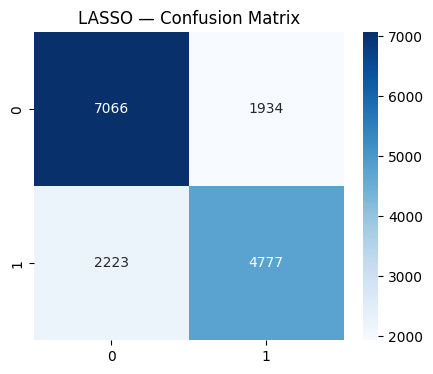


----- RIDGE -----
Precision: 0.7119
Recall:    0.6830
F1 Score:  0.6971
AUC:       0.8146
              precision    recall  f1-score   support

           0       0.76      0.79      0.77      9000
           1       0.71      0.68      0.70      7000

    accuracy                           0.74     16000
   macro avg       0.74      0.73      0.73     16000
weighted avg       0.74      0.74      0.74     16000



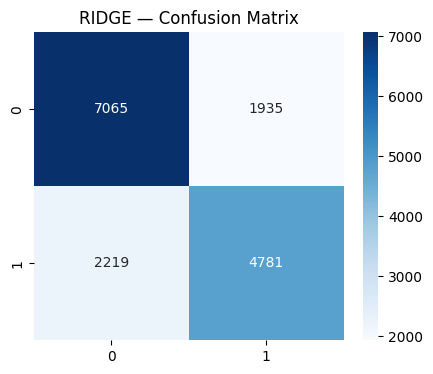


----- RF -----
Precision: 0.7773
Recall:    0.7207
F1 Score:  0.7480
AUC:       0.8622
              precision    recall  f1-score   support

           0       0.79      0.84      0.82      9000
           1       0.78      0.72      0.75      7000

    accuracy                           0.79     16000
   macro avg       0.79      0.78      0.78     16000
weighted avg       0.79      0.79      0.79     16000



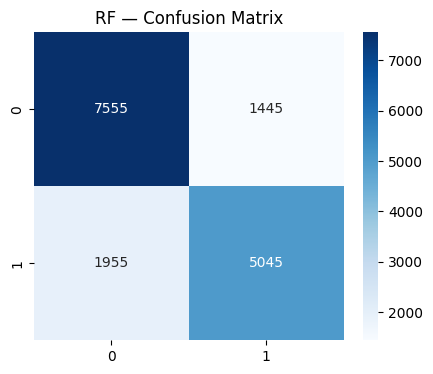


----- HGB -----
Precision: 0.7955
Recall:    0.7026
F1 Score:  0.7462
AUC:       0.8657
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      9000
           1       0.80      0.70      0.75      7000

    accuracy                           0.79     16000
   macro avg       0.79      0.78      0.78     16000
weighted avg       0.79      0.79      0.79     16000



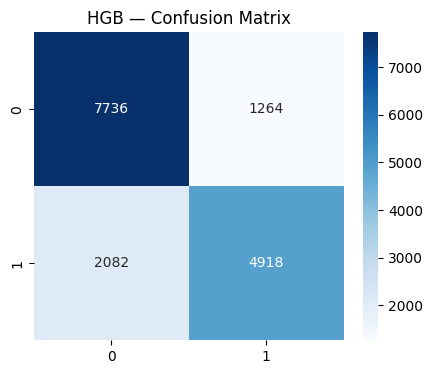

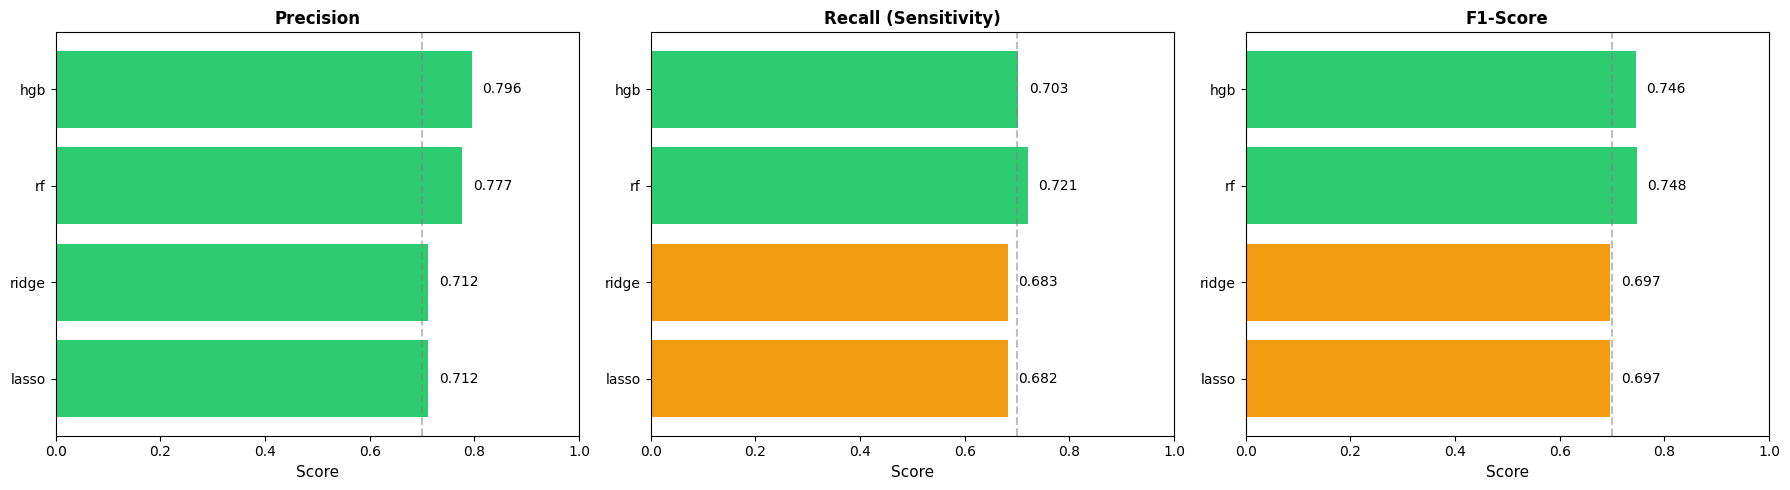

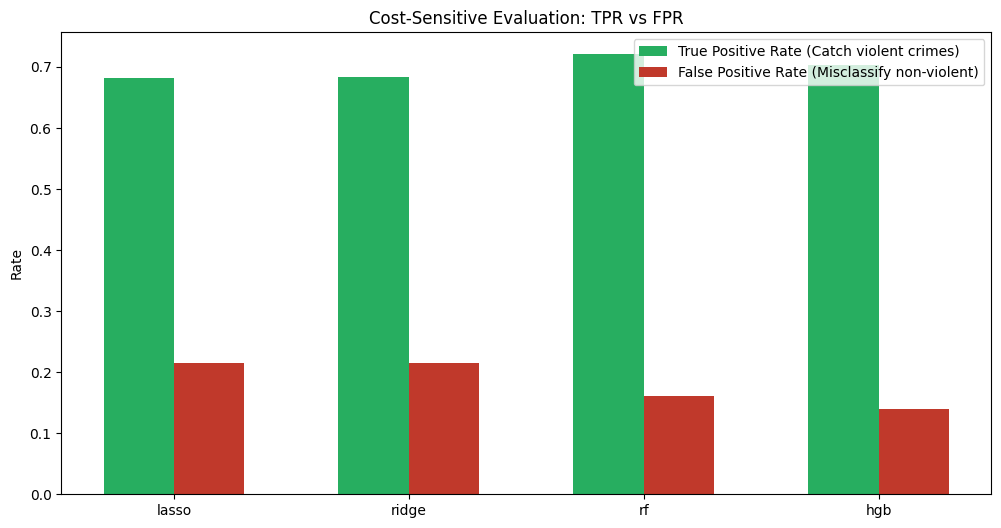

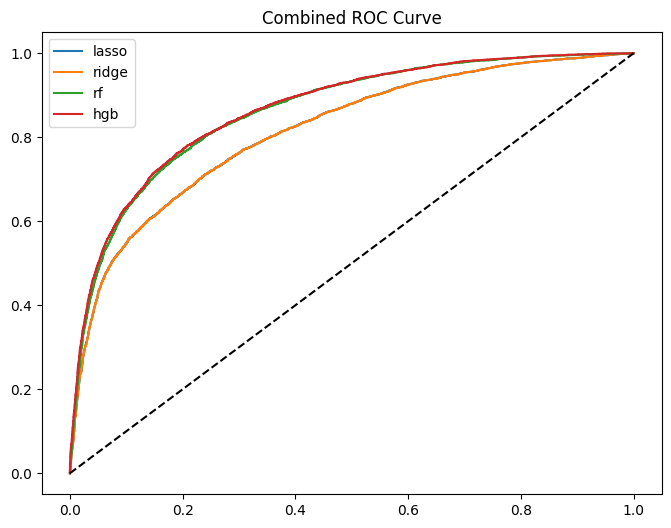

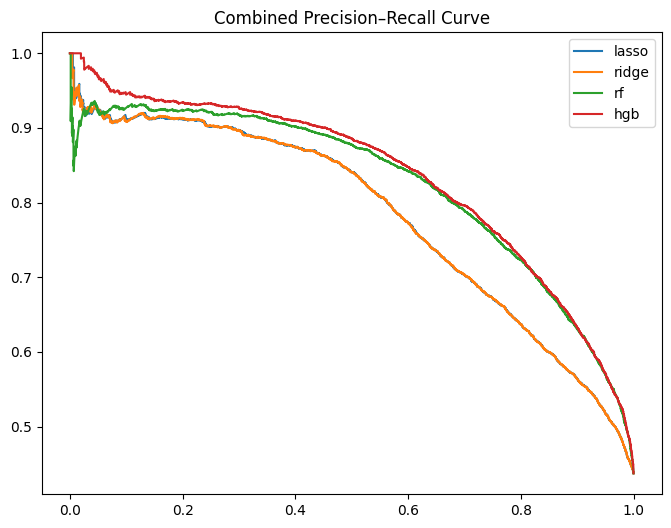

In [3]:
from sklearn.metrics import (
    roc_curve, precision_recall_curve,
    precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Storing metrics values for model comparison
model_metrics = {}

# Evaluation Function
def evaluate(name, model):
    preds = model.predict(X_test)

    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    try:
        proba = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, proba)
    except:
        auc_score = np.nan

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    TN, FP, FN, TP = cm.ravel()

    TPR = TP / (TP + FN)        
    FPR = FP / (FP + TN)

    model_metrics[name] = {
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc_score,
        "TPR": TPR,
        "FPR": FPR
    }

    # Evaluation Summary
    print(f"\n----- {name.upper()} -----")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC:       {auc_score:.4f}")
    print(classification_report(y_test, preds))

    # Confusion matrix 
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name.upper()} — Confusion Matrix")
    plt.show()

for name, model in final_models.items():
    evaluate(name, model)


# Bar charts
models = list(model_metrics.keys())
models_lower = [m.lower() for m in models]

prec_vals = [model_metrics[m]["Precision"] for m in models]
rec_vals  = [model_metrics[m]["Recall"] for m in models]
f1_vals   = [model_metrics[m]["F1"] for m in models]

GREEN = "#2ecc71"
ORANGE = "#f39c12"

prec_colors = [GREEN for _ in models]
rec_colors    = [GREEN if r >= 0.70 else ORANGE for r in rec_vals]
f1_colors        = [GREEN if f >= 0.70 else ORANGE for f in f1_vals]

# F1 vs Recall vs Precision Trade-off
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

comprehensive_metrics = {
    "Model": models_lower,
    "Precision": prec_vals,
    "Recall (Sensitivity)": rec_vals,
    "F1-Score": f1_vals
}

metric_names = ["Precision", "Recall (Sensitivity)", "F1-Score"]

for idx, metric in enumerate(metric_names):
    ax = axes[idx]
    values = comprehensive_metrics[metric]
    colors = [
        "#2ecc71" if v > 0.7 else
        "#f39c12" if v > 0.6 else
        "#e74c3c"
        for v in values
    ]

    ax.barh(comprehensive_metrics["Model"], values, color=colors)
    ax.set_xlim([0, 1])
    ax.set_xlabel("Score", fontsize=11)
    ax.set_title(metric, fontweight="bold", fontsize=12)
    ax.axvline(x=0.7, color="gray", linestyle="--", alpha=0.5)

    for i, (model, val) in enumerate(zip(comprehensive_metrics["Model"], values)):
        ax.text(val + 0.02, i, f"{val:.3f}", va="center", fontsize=10)

plt.tight_layout()
plt.show()


# Cost-Sensitive Evaluation
tpr_list = [model_metrics[m]["TPR"] for m in models]
fpr_list = [model_metrics[m]["FPR"] for m in models]

x = np.arange(len(models))

plt.figure(figsize=(12,6))
plt.bar(x - 0.15, tpr_list, width=0.3, color="#27ae60", label="True Positive Rate (Catch violent crimes)")
plt.bar(x + 0.15, fpr_list, width=0.3, color="#c0392b", label="False Positive Rate (Misclassify non-violent)")
plt.xticks(x, models_lower)
plt.title("Cost-Sensitive Evaluation: TPR vs FPR")
plt.ylabel("Rate")
plt.legend()
plt.show()


# Combined ROC Curve
plt.figure(figsize=(8,6))
for name, model in final_models.items():
    try:
        proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, proba)
        plt.plot(fpr, tpr, label=name)
    except:
        pass

plt.plot([0,1], [0,1], "k--")
plt.title("Combined ROC Curve")
plt.legend()
plt.show()


# Combined PR Curve
plt.figure(figsize=(8,6))
for name, model in final_models.items():
    try:
        proba = model.predict_proba(X_test)[:,1]
        prec_curve, rec_curve, _ = precision_recall_curve(y_test, proba)
        plt.plot(rec_curve, prec_curve, label=name)
    except:
        pass

plt.title("Combined Precision–Recall Curve")
plt.legend()
plt.show()

In [4]:
# Feature Importance

def get_feature_importance_df(model, model_name, feature_names):
    m = model.named_steps["model"]

    # Linear model (LASSO / Ridge)
    if hasattr(m, "coef_"):
        importance = np.abs(m.coef_[0])

    # Tree model (Random Forest)
    elif hasattr(m, "feature_importances_"):
        importance = m.feature_importances_

    else:
        # Handles when no feature importance attribute in model
        return pd.DataFrame(columns=["feature", "importance", "model"])

    min_len = min(len(importance), len(feature_names))
    importance = importance[:min_len]
    feature_names = feature_names[:min_len]

    df = pd.DataFrame({
        "feature": feature_names,
        "importance": importance
    }).sort_values("importance", ascending=False).head(15)

    df["model"] = model_name
    return df


# Feature importance of LASSO, Ridge, Random Forest models

fi_lasso = get_feature_importance_df(final_models["lasso"], "LASSO", encoded_feature_names)
fi_ridge = get_feature_importance_df(final_models["ridge"], "Ridge", encoded_feature_names)
fi_rf    = get_feature_importance_df(final_models["rf"], "RandomForest", encoded_feature_names)

# Combine all feature importances
all_fi = pd.concat([fi_lasso, fi_ridge, fi_rf], ignore_index=True)


print(" TOP 15 FEATURES — LASSO")
print(fi_lasso[["feature", "importance"]].to_string(index=False))
print("-"*80)

print(" TOP 15 FEATURES — RIDGE")
print(fi_ridge[["feature", "importance"]].to_string(index=False))
print("-"*80)

print(" TOP 15 FEATURES — RANDOM FOREST")
print(fi_rf[["feature", "importance"]].to_string(index=False))


 TOP 15 FEATURES — LASSO
                                       feature  importance
                          premis_desc_MAIL BOX    4.751416
              premis_desc_TRANSIENT ENCAMPMENT    3.084921
                    premis_desc_PUBLIC STORAGE    2.743840
    premis_desc_AUTOMATED TELLER MACHINE (ATM)    2.315166
                        premis_desc_CYBERSPACE    2.282414
premis_desc_TRANSITIONAL HOUSING/HALFWAY HOUSE    2.272069
                status_desc_infrequent_sklearn    2.089025
                          premis_desc_SIDEWALK    1.945516
                       status_desc_Adult Other    1.814616
                             premis_desc_BEACH    1.785685
                           premis_desc_MTA BUS    1.777160
                        status_desc_Juv Arrest    1.745178
      premis_desc_PARKING UNDERGROUND/BUILDING    1.744392
                    premis_desc_GARAGE/CARPORT    1.710874
                premis_desc_PORCH, RESIDENTIAL    1.676085
-------------------------------

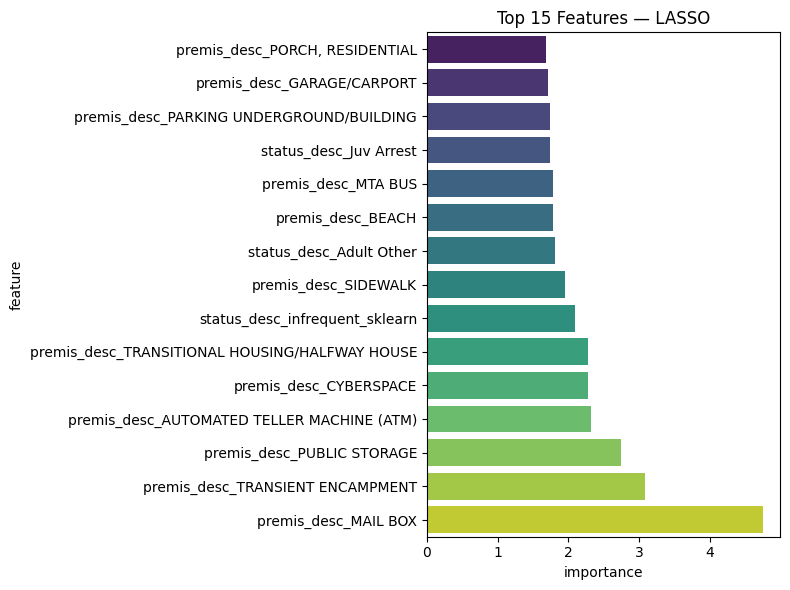

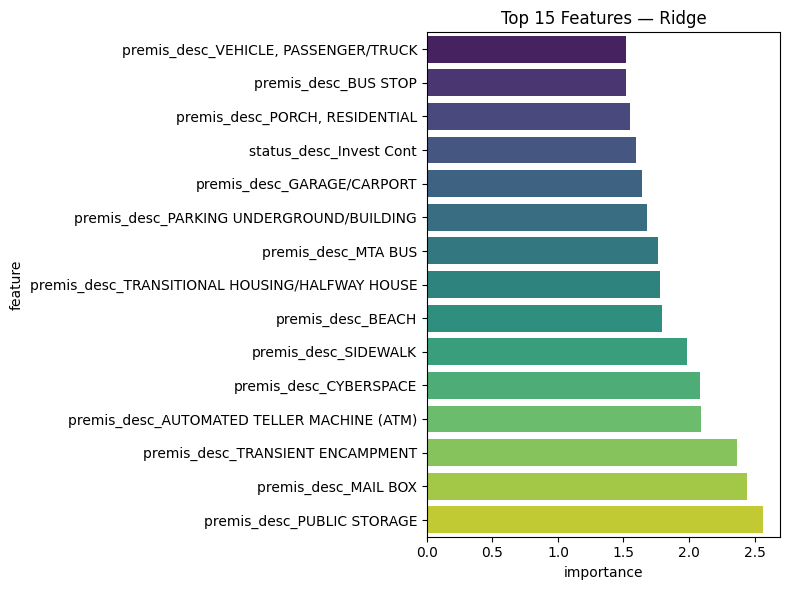

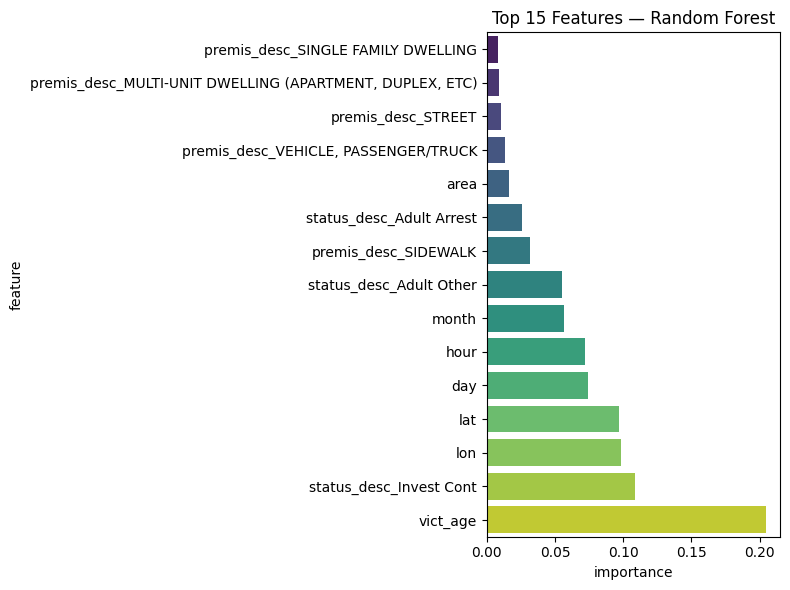

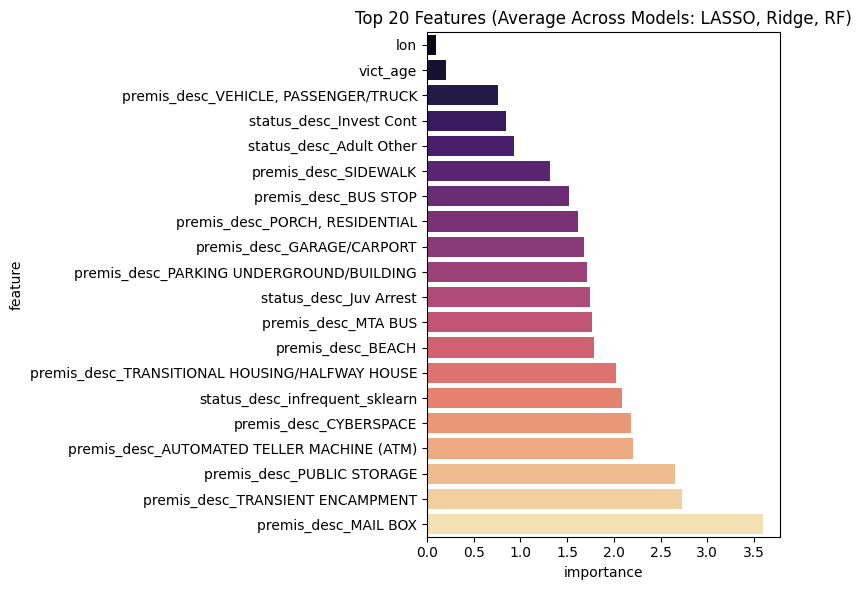

In [5]:
# Feature Importance Visualizations

import seaborn as sns
import matplotlib.pyplot as plt


def plot_top_features(df, title):
    df_sorted = df.sort_values("importance")

    plt.figure(figsize=(8,6))
    sns.barplot(
        data=df_sorted,
        x="importance",
        y="feature",
        hue="feature",    
        palette="viridis",
        legend=False      
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_top_features(fi_lasso, "Top 15 Features — LASSO")
plot_top_features(fi_ridge, "Top 15 Features — Ridge")
plot_top_features(fi_rf, "Top 15 Features — Random Forest")


global_df = (
    all_fi.groupby("feature")["importance"]
    .mean()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
)

plt.figure(figsize=(8,6))
sns.barplot(
    data=global_df.sort_values("importance"),
    x="importance",
    y="feature",
    hue="feature",    
    palette="magma",
    legend=False
)
plt.title("Top 20 Features (Average Across Models: LASSO, Ridge, RF)")
plt.tight_layout()
plt.show()
